In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [3]:
import cv2
import pandas as pd
import os
import numpy as np
from skimage.metrics import structural_similarity as ssim
import math
import random
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity, mean_squared_error
from skimage import color, filters

# DIRS-CLAHS Implementation


## Evaluation Metrics

In [4]:
def calculate_mse(img1, img2):
    """Compute Mean Squared Error (MSE) between two images."""
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    mse_val = np.mean((img1.astype("float") - img2.astype("float")) ** 2)
    return mse_val

def calculate_psnr(img1, img2):
    """Compute Peak Signal-to-Noise Ratio (PSNR) between two images."""
    mse_val = calculate_mse(img1, img2)
    if mse_val == 0:
        return float('inf')
    max_pixel = 255.0
    psnr_val = 20 * math.log10(max_pixel / math.sqrt(mse_val))
    return psnr_val

def calculate_ssim(img1, img2):
    """Compute Structural Similarity Index (SSIM) between two images."""
    if img1.shape != img2.shape:
        img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))
    ssim_val = structural_similarity(img1, img2, channel_axis=2)
    return ssim_val

def compute_uciqe(img):
    """
    Compute Underwater Color Image Quality Evaluation (UCIQE) metric.
    A simplified version using:
        UCIQE = 0.4680 * std_chroma + 0.2745 * contrast_luminance + 0.2576 * mean_saturation
    """
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    lab = color.rgb2lab(img_rgb)
    L, a, b = lab[:,:,0], lab[:,:,1], lab[:,:,2]
    chroma = np.sqrt(a**2 + b**2)
    std_chroma = np.std(chroma)
    # Use percentiles for luminance contrast
    contrast_luminance = np.percentile(L, 99) - np.percentile(L, 1)
    # Compute saturation as normalized chroma (simple approximation)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    S = hsv[:,:,1] / 255.0
    mean_saturation = np.mean(S)

    uciqe_val = 0.4680 * std_chroma + 0.2745 * contrast_luminance + 0.2576 * mean_saturation
    return uciqe_val

def compute_uiqm(img):
    """
    Compute Underwater Image Quality Measure (UIQM) metric.
    This simplified version computes sub-measures:
        - UICM: Colorfulness measure
        - UISM: Sharpness measure via Sobel operator and block energy
        - UIConM: Contrast measure via logarithmic AME in patches
    and then a weighted sum.
    """
    # --- UICM (Colorfulness measure) ---
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    R, G, B = cv2.split(img_rgb.astype(np.float32))
    rg = R - G
    yb = 0.5 * (R + G) - B
    uicm_val = -0.0268 * np.sqrt(np.mean(rg)**2 + np.mean(yb)**2) + 0.1586 * np.sqrt(np.var(rg) + np.var(yb))

    # --- UISM (Sharpness measure) ---
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Using variance of the Sobel gradient as a simple sharpness measure
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = cv2.magnitude(grad_x, grad_y)
    uism_val = np.var(gradient_magnitude)

    # --- UIConM (Contrast measure) ---
    gray_norm = gray.astype(np.float32) / 255.0
    # Compute average local contrast in 4x4 blocks using log contrast
    def log_contrast(channel, window_size=4):
        H, W = channel.shape
        total_contrast = 0
        count = 0
        for i in range(0, H, window_size):
            for j in range(0, W, window_size):
                patch = channel[i:i+window_size, j:j+window_size]
                if patch.size == 0:
                    continue
                I_max = patch.max() + 1e-6
                I_min = patch.min() + 1e-6
                total_contrast += np.log10(I_max / I_min)
                count += 1
        return total_contrast / (count + 1e-6)
    uiconm_val = log_contrast(gray_norm, window_size=4)

    # Combine UIQM sub-measures with example weights
    uiqm_val = 0.0282 * uicm_val + 0.2953 * uism_val + 3.5753 * uiconm_val
    return uiqm_val

## DIRS-CLAHS Pipeline

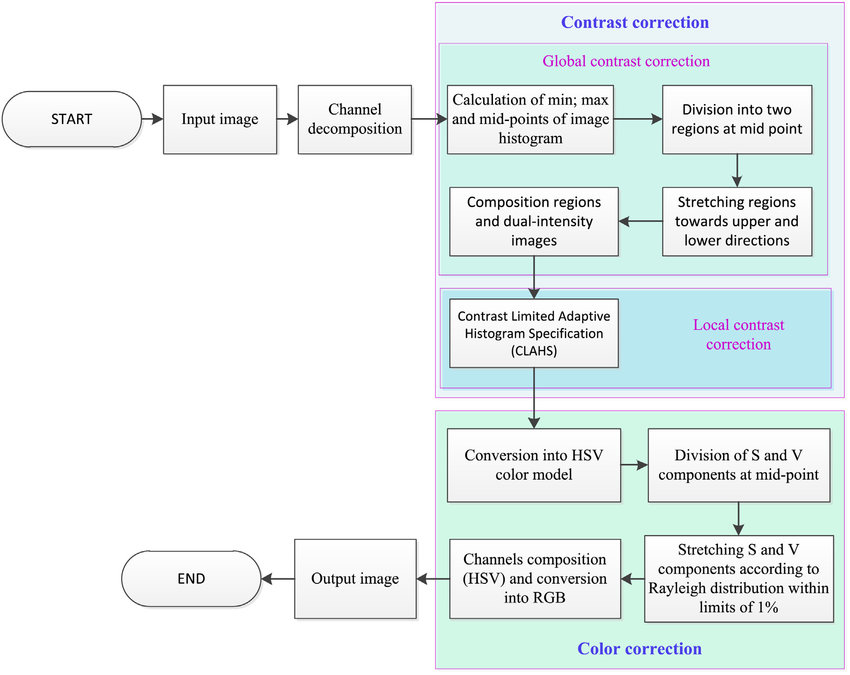

In [5]:
def global_contrast_correction(img):
    """
    Global Contrast Correction:
    - Compute min, max, midpoint of histogram (per channel).
    - Divide into two regions at midpoint.
    - Stretch lower region [min, midpoint] -> [0, 127]
      and upper region [midpoint, max] -> [128, 255].
    """
    corrected = np.zeros_like(img)
    for c in range(3):
        channel = img[:, :, c].astype(np.float32)
        c_min = np.min(channel)
        c_max = np.max(channel)

        # Avoid division-by-zero if channel is flat
        if c_max == c_min:
            corrected[:, :, c] = channel
            continue

        midpoint = (c_min + c_max) / 2.0

        lower_mask = channel < midpoint
        upper_mask = channel >= midpoint

        corrected_channel = np.zeros_like(channel)
        denominator_lower = (midpoint - c_min) if (midpoint - c_min) != 0 else 1e-5
        corrected_channel[lower_mask] = ((channel[lower_mask] - c_min) / denominator_lower) * 127.0

        denominator_upper = (c_max - midpoint) if (c_max - midpoint) != 0 else 1e-5
        corrected_channel[upper_mask] = 128.0 + ((channel[upper_mask] - midpoint) / denominator_upper) * 127.0

        corrected[:, :, c] = corrected_channel

    corrected = np.clip(corrected, 0, 255).astype(np.uint8)
    return corrected

def local_contrast_correction(img):
    """
    Local Contrast Correction using CLAHE (Contrast Limited Adaptive Histogram Equalization).
    For demonstration, we apply CLAHE on the Y channel of YCrCb space.
    """
    ycrcb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    y, Cr, Cb = cv2.split(ycrcb)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    y_clahe = clahe.apply(y)

    merged = cv2.merge((y_clahe, Cr, Cb))
    corrected = cv2.cvtColor(merged, cv2.COLOR_YCrCb2BGR)
    return corrected

def color_correction(img):
    """
    Color Correction:
    1) Convert to HSV
    2) Split S and V channels, compute min, max, midpoint
       and piecewise stretch them (approx. Rayleigh distribution).
    3) Merge back and convert to BGR.
    """
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV).astype(np.float32)
    H, S, V = cv2.split(hsv)

    def piecewise_stretch(channel):
        c_min = np.min(channel)
        c_max = np.max(channel)
        if c_max == c_min:
            return channel
        midpoint = (c_min + c_max) / 2.0

        lower_mask = channel < midpoint
        upper_mask = channel >= midpoint

        stretched = np.zeros_like(channel)

        denominator_lower = (midpoint - c_min) if (midpoint - c_min) != 0 else 1e-5
        stretched[lower_mask] = ((channel[lower_mask] - c_min) / denominator_lower) * 127.0

        denominator_upper = (c_max - midpoint) if (c_max - midpoint) != 0 else 1e-5
        stretched[upper_mask] = 128.0 + ((channel[upper_mask] - midpoint) / denominator_upper) * 127.0

        return stretched

    # Stretch S and V
    S_stretched = piecewise_stretch(S)
    V_stretched = piecewise_stretch(V)

    # Merge and convert back
    hsv_corrected = cv2.merge((H, S_stretched, V_stretched))
    corrected_bgr = cv2.cvtColor(hsv_corrected.astype(np.uint8), cv2.COLOR_HSV2BGR)
    return corrected_bgr

In [6]:
def process_image_pipeline(input_path, reference_path=None):
    """
    1) Reads input image.
    2) Performs Global Contrast Correction.
    3) Performs Local Contrast Correction.
    4) Performs Color Correction.
    5) Returns a dictionary with all intermediate steps and the final output.
    6) Always computes no-reference metrics (UIQM, UCIQE).
       If reference_path is provided, computes full-reference metrics (PSNR, SSIM, MSE)
       and adds them to the metrics dictionary.
    """
    img = cv2.imread(input_path)
    if img is None:
        raise ValueError(f"Could not read input image from {input_path}")
    global_corrected = global_contrast_correction(img)
    local_corrected = local_contrast_correction(global_corrected)
    final_output = color_correction(local_corrected)
    results = {
    "Original": img,
    "global_contrast": global_corrected,
    "local_contrast": local_corrected,
    "final_output": final_output
    }

    if reference_path is not None:
        ref = cv2.imread(reference_path)
        if ref is None:
            raise ValueError(f"Could not read reference image from {reference_path}")

        if ref.shape != final_output.shape:
            ref = cv2.resize(ref, (final_output.shape[1], final_output.shape[0]))
        results["reference"] = ref

    return results

def evaluate_image(final_output, ref=None):
    """
    Evaluates the final output image.

    Always computes no-reference metrics (UIQM, UCIQE).
    If a reference_path is provided, computes full-reference metrics (PSNR, SSIM, MSE)
    after resizing the reference image (if needed).

    Returns a tuple:
        (metrics_dict, reference_image)
    where metrics_dict is a dictionary containing:
        - PSNR, SSIM, MSE (or None if reference_path is not provided)
        - UIQM, UCIQE
    and reference_image is the loaded (and resized) reference image, or None.
    """

    uiqm_val = compute_uiqm(final_output)
    uciqe_val = compute_uciqe(final_output)

    if ref is not None:
        if ref.shape != final_output.shape:
            ref = cv2.resize(ref, (final_output.shape[1], final_output.shape[0]))

        psnr_val = calculate_psnr(final_output, ref)
        ssim_val = calculate_ssim(final_output, ref)
        mse_val  = calculate_mse(final_output, ref)

        metrics_dict = {
            "PSNR": psnr_val,
            "SSIM": ssim_val,
            "MSE": mse_val,
            "UIQM": uiqm_val,
            "UCIQE": uciqe_val
        }
        return metrics_dict
    else:
        metrics_dict = {
            "PSNR": None,
            "SSIM": None,
            "MSE": None,
            "UIQM": uiqm_val,
            "UCIQE": uciqe_val
        }
        return metrics_dict

## Running DIRS-CLAHS

In [7]:
%%time
random.seed(42)
input_folder = "/content/drive/MyDrive/UIEB_Dataset/raw"
ref_folder = "/content/drive/MyDrive/UIEB_Dataset/reference"

input_files = sorted(os.listdir(input_folder))


n_total = len(input_files)
n_samples = 100 if n_total >= 100 else n_total

sample_indices = random.sample(range(n_total), n_samples)

all_outputs = {}


for idx in sample_indices:
    img_name = input_files[idx]

    img_path = os.path.join(input_folder, img_name)
    ref_path = os.path.join(ref_folder, img_name)
    results = process_image_pipeline(img_path, ref_path)
    all_outputs[img_name] = results

print("Processing complete. Stored outputs for", len(all_outputs), "images.")



Processing complete. Stored outputs for 100 images.
CPU times: user 12.7 s, sys: 1.35 s, total: 14.1 s
Wall time: 4min 26s


## Evaluating DIRS-CLAHS results

In [8]:
metrics_list = []

for img_name, result in all_outputs.items():
    final_output = result["final_output"]
    ref_img = result.get("reference", None)
    metrics_dict = evaluate_image(final_output, ref_img)
    metrics_dict["image_name"] = img_name
    metrics_list.append(metrics_dict)

metrics_df = pd.DataFrame(metrics_list)

In [9]:
metrics_df.head()

PSNR      SSIM          MSE         UIQM      UCIQE    image_name
0  18.268412  0.878382   968.811321  1442.946644  25.124974   70_img_.png
1  17.787973  0.910990  1082.139103   643.083541  26.137013  184_img_.png
2  20.274971  0.802658   610.356120  2574.626537  29.766421  118_img_.png
3  17.410896  0.823205  1180.295500  7054.781182  29.478121  806_img_.png
4  18.118133  0.851638  1002.921802  5422.966042  30.061836  346_img_.png

In [10]:
metrics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   PSNR        100 non-null    float64
 1   SSIM        100 non-null    float64
 2   MSE         100 non-null    float64
 3   UIQM        100 non-null    float64
 4   UCIQE       100 non-null    float64
 5   image_name  100 non-null    object 
dtypes: float64(5), object(1)
memory usage: 4.8+ KB


Saving Results

In [11]:
destination_folder = "/content/drive/MyDrive/UIEB_Dataset/Results"
image_keys = ["global_contrast", "local_contrast", "final_output"]
for key in image_keys:
    folder_path = os.path.join(destination_folder, key)
    os.makedirs(folder_path, exist_ok=True)
for img_name, outputs in all_outputs.items():
    for key in image_keys:
        if key in outputs:
            img = outputs[key]
            save_path = os.path.join(destination_folder, key, img_name)
            cv2.imwrite(save_path, img)


In [12]:
import pickle

with open('/content/drive/MyDrive/UIEB_Dataset/Results/DIRS_outputs.pkl', 'wb') as f:
    pickle.dump(all_outputs, f)


In [13]:
metrics_df.to_csv('/content/drive/MyDrive/UIEB_Dataset/Results/metrics.csv')

## Metrics Bar Plot DIRS_CLAHS

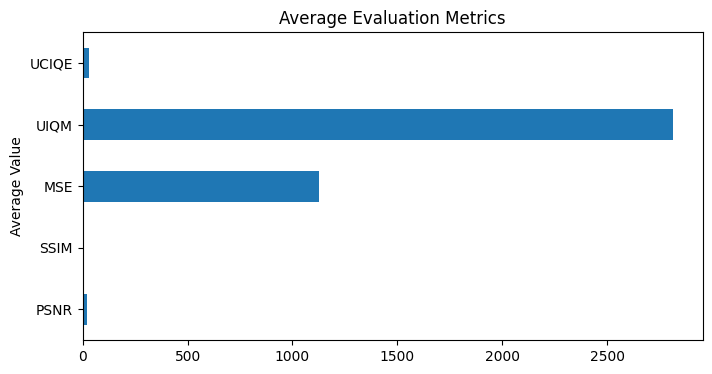

In [14]:
numeric_metrics = metrics_df.select_dtypes(include=["number"])

avg_metrics = numeric_metrics.mean()
avg_metrics.plot(kind="barh", figsize=(8, 4), title="Average Evaluation Metrics")
plt.ylabel("Average Value")
plt.show()


In [40]:
with open('/content/drive/MyDrive/UIEB_Dataset/Results/DIRS_outputs.pkl', 'rb') as f:
    DIRS_outputs = pickle.load(f)

In [41]:
DIRS_outputs.keys()

dict_keys(['70_img_.png', '184_img_.png', '118_img_.png', '806_img_.png', '346_img_.png', '312_img_.png', '293_img_.png', '208_img_.png', '802_img_.png', '174_img_.png', '748_img_.png', '8056.png', '617_img_.png', '161_img_.png', '660_img_.png', '501_img_.png', '122_img_.png', '12290.png', '166_img_.png', '2882.png', '300_img_.png', '5830.png', '677_img_.png', '120_img_.png', '632_img_.png', '2701.png', '785_img_.png', '721_img_.png', '770_img_.png', '9554.png', '498_img_.png', '28_img_.png', '532_img_.png', '65_img_.png', '35.png', '878_img_.png', '105_img_.png', '823_img_.png', '875_img_.png', '22_img_.png', '767_img_.png', '92_img_.png', '416_img_.png', '912_img_.png', '226_img_.png', '284_img_.png', '828_img_.png', '411_img_.png', '95_img_.png', '1660.png', '459_img_.png', '170_img_.png', '438_img_.png', '41_img_.png', '678_img_.png', '332_img_.png', '876_img_.png', '130_img_.png', '797_img_.png', '541_img_.png', '609_img_.png', '195_img_.png', '457_img_.png', '155_img_.png', '623_

## Visualizing Results

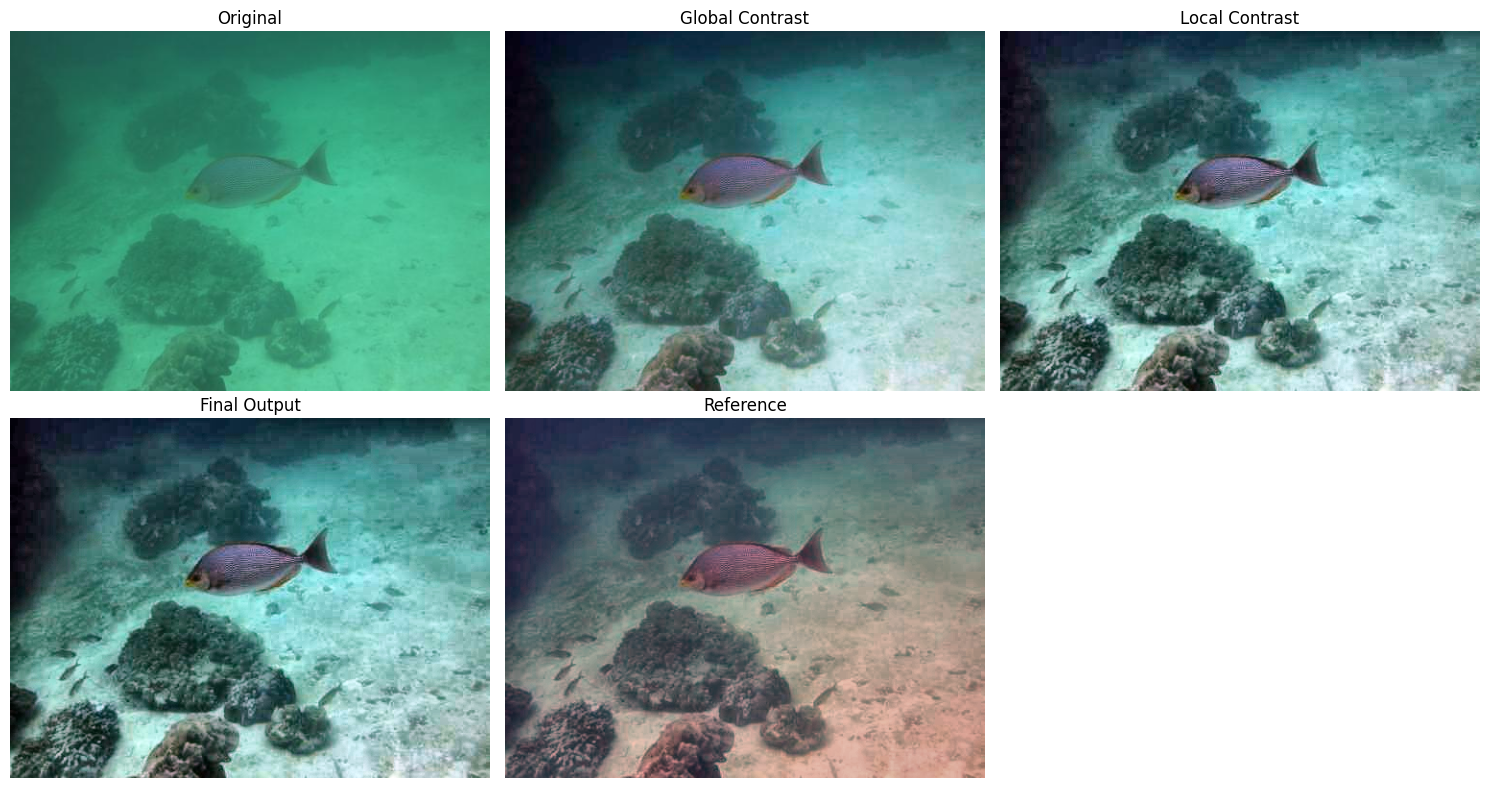

In [45]:

def plot_pipeline_results(outputs):
    """
    Plot intermediate results (images) from the enhancement pipeline,
    assigning subplot titles dynamically from the dictionary keys.

    Parameters:
        outputs (dict): A dictionary that may include:
            - Image keys (e.g. "original", "final") mapped to np.ndarray images (BGR).
            - Non-image keys (e.g. "metrics") mapped to other data types.
    """

    image_keys = [k for k, v in outputs.items() if isinstance(v, np.ndarray)]

    n_images = len(image_keys)
    if n_images == 0:
        print("No images to plot.")
        return

    n_cols = 3
    n_rows = math.ceil(n_images / n_cols)

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = np.array(axes).flatten()

    for idx, key in enumerate(image_keys):
        img_bgr = outputs[key]
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        axes[idx].imshow(img_rgb)
        title_str = " ".join([word.capitalize() for word in key.split("_")])
        axes[idx].set_title(title_str)

        axes[idx].axis("off")

    for j in range(n_images, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_pipeline_results(DIRS_outputs['607_img_.png'])

# Proposed Improvements

## Improvement Pipeline

In [17]:

def global_contrast_correction(img):
    """
    Apply Global Contrast Correction using a piecewise linear stretch.
    This function computes the 5th and 95th percentile for each channel
    and then stretches the pixel values to [0,255].
    """
    img_float = img.astype(np.float32)
    channels = cv2.split(img_float)
    stretched_channels = []
    for ch in channels:
        low_val = np.percentile(ch, 5)
        high_val = np.percentile(ch, 95)
        if high_val - low_val < 1e-3:
            stretched = ch
        else:
            stretched = (ch - low_val) / (high_val - low_val) * 255.0
        stretched = np.clip(stretched, 0, 255)
        stretched_channels.append(stretched)
    img_global = cv2.merge(stretched_channels).astype(np.uint8)
    return img_global

def color_attenuation_compensation(img):
    """
    Apply Color Attenuation Compensation (CAC) to rebalance color channels.
    This simple method boosts the red channel (which is typically attenuated underwater)
    based on the average intensities of the channels.
    """
    B, G, R = cv2.split(img)
    meanR, meanG, meanB = np.mean(R), np.mean(G), np.mean(B)

    # Compute red compensation factor: boost red to match average of green and blue
    red_boost = ((meanG + meanB) / 2.0) / (meanR + 1e-6)
    red_boost = np.clip(red_boost, 1.0, 3.0)
    R_corrected = np.clip(R * red_boost, 0, 255).astype(np.uint8)
    B_corrected = np.clip(B * 0.9, 0, 255).astype(np.uint8)
    G_corrected = G.copy()
    img_cac = cv2.merge([B_corrected, G_corrected, R_corrected])
    return img_cac


def adaptive_local_enhancement(img):
    """
    Apply Adaptive CLAHE on the L channel in LAB color space.
    The clip limit is adapted based on the average luminance.
    """
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    avg_luminance = np.mean(L)
    clip_limit = 3.0 if avg_luminance < 100 else 2.0
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(8, 8))
    L_clahe = clahe.apply(L)
    lab_clahe = cv2.merge([L_clahe, A, B])
    img_local = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2BGR)
    return img_local

def single_scale_retinex(img_float, sigma):
    """Compute Single-Scale Retinex for one scale."""
    blur = cv2.GaussianBlur(img_float, (0, 0), sigma)
    retinex = np.log10(img_float + 1e-6) - np.log10(blur + 1e-6)
    return retinex


def multi_scale_retinex(img_bgr, scales=[15, 80], weights=[0.5, 0.5],
          alpha=1.0, beta=0.0,
          color_restoration_factor=2.0, color_restoration_offset=1.0):
    """
    Multi-Scale Retinex with Color Restoration (MSRCR).

    Parameters:
        img_bgr: Input BGR image (uint8).
        scales: List of Gaussian sigmas for Multi-Scale Retinex.
        weights: Corresponding weights (should sum to 1).
        alpha, beta: Gain and offset applied to final MSRCR result.
        color_restoration_factor (CRF) and color_restoration_offset:
            used in a simplified color restoration function:
            CRF(I_c) = color_restoration_factor * log10(color_restoration_offset * I_c + 1)
    """
    img_float = img_bgr.astype(np.float32) / 255.0
    B, G, R = cv2.split(img_float)
    channels = [B, G, R]
    msr_channels = []
    for c in channels:
        msr = np.zeros_like(c)
        for sigma, w in zip(scales, weights):
            msr += w * single_scale_retinex(c, sigma)
        msr_channels.append(msr)

    # 3) Color Restoration Function (for each channel)
    #    CRF(I_c) = factor * log10(offset * I_c + 1)
    restored_channels = []
    for c, msr_c in zip(channels, msr_channels):
        # CRF
        CRF = color_restoration_factor * np.log10(color_restoration_offset * c + 1.0)
        # Combine MSR and CRF
        msrcr_c = alpha * msr_c * CRF + beta
        restored_channels.append(msrcr_c)

    # Merge channels
    msrcr_merged = cv2.merge(restored_channels)

    # 4) Normalize to [0..1]
    min_val = np.min(msrcr_merged)
    max_val = np.max(msrcr_merged)
    msrcr_norm = (msrcr_merged - min_val) / (max_val - min_val + 1e-6)

    # 5) Scale to [0..255] and convert back to uint8
    img_msrcr = np.clip(msrcr_norm * 255, 0, 255).astype(np.uint8)
    return img_msrcr

def gamma_correction(img, gamma=1.2):
    if img.dtype != np.uint8:
        img = np.clip(img, 0, 255).astype(np.uint8)
    # Build a LUT
    table = np.array([((i / 255.0) ** (1.0 / gamma)) * 255
                      for i in np.arange(256)]).astype(np.uint8)
    return cv2.LUT(img, table)

In [28]:

def process_image_pipeline(input_path, reference_path=None):
    """
    1) Reads input image.
    2) Performs Color Attenuation Compensation
    3) Performs Global Contrast Correction.
    4) Performs Local Contrast Correction.
    5) Performs Multiscale Retinex.
    6) Performs Gamma Correction.
    7) Performs Alpha Blending.
    8) Returns a dictionary with all intermediate steps and the final output.
    9) Always computes no-reference metrics (UIQM, UCIQE).
       If reference_path is provided, computes full-reference metrics (PSNR, SSIM, MSE)
       and adds them to the metrics dictionary.
    """
    img = cv2.imread(input_path)
    if img is None:
        raise ValueError(f"Could not read input image from {input_path}")
    img_cac = color_attenuation_compensation(img)
    img_global = global_contrast_correction(img_cac)
    img_local = adaptive_local_enhancement(img_global)
    img_final = multi_scale_retinex(img_local)
    img_final = gamma_correction(img_final, gamma=1.2)
    alpha = 0.3
    img_final = cv2.addWeighted(img_final, alpha, img_local, 1 - alpha, 0)


    results = {
        "original": img,
        "cac": img_cac,
        "global_contrast": img_global,
        "local_enhancement": img_local,
        "final_output": img_final
        }

    if reference_path is not None:
        ref = cv2.imread(reference_path)
        if ref is None:
            raise ValueError(f"Could not read reference image from {reference_path}")

        if ref.shape != final_output.shape:
            ref = cv2.resize(ref, (final_output.shape[1], final_output.shape[0]))
        results["reference"] = ref

    return results

# Evaluation Function
def evaluate_image(final_output, ref=None):
    """
    Evaluates the final output image.

    Always computes no-reference metrics (UIQM, UCIQE).
    If a reference_path is provided, computes full-reference metrics (PSNR, SSIM, MSE)
    after resizing the reference image (if needed).

    Returns a tuple:
        (metrics_dict, reference_image)
    where metrics_dict is a dictionary containing:
        - PSNR, SSIM, MSE (or None if reference_path is not provided)
        - UIQM, UCIQE
    and reference_image is the loaded (and resized) reference image, or None.
    """

    uiqm_val = compute_uiqm(final_output)
    uciqe_val = compute_uciqe(final_output)

    if ref is not None:
        if ref.shape != final_output.shape:
            ref = cv2.resize(ref, (final_output.shape[1], final_output.shape[0]))

        psnr_val = calculate_psnr(final_output, ref)
        ssim_val = calculate_ssim(final_output, ref)
        mse_val  = calculate_mse(final_output, ref)

        metrics_dict = {
            "PSNR": psnr_val,
            "SSIM": ssim_val,
            "MSE": mse_val,
            "UIQM": uiqm_val,
            "UCIQE": uciqe_val
        }
        return metrics_dict
    else:
        metrics_dict = {
            "PSNR": None,
            "SSIM": None,
            "MSE": None,
            "UIQM": uiqm_val,
            "UCIQE": uciqe_val
        }
        return metrics_dict




In [31]:
%%time
all_outputs = {}
for idx in sample_indices:
    img_name = input_files[idx]

    img_path = os.path.join(input_folder, img_name)
    ref_path = os.path.join(ref_folder, img_name)
    results = process_image_pipeline(img_path, ref_path)
    all_outputs[img_name] = results

print("Processing complete. Stored outputs for", len(all_outputs), "images.")



Processing complete. Stored outputs for 100 images.
CPU times: user 1min 39s, sys: 1.16 s, total: 1min 41s
Wall time: 1min 45s


## Evaluation after Improvement

In [32]:
metrics_list = []

for img_name, result in all_outputs.items():
    final_output = result["final_output"]
    ref_img = result.get("reference", None)
    metrics_dict = evaluate_image(final_output, ref_img)
    metrics_dict["image_name"] = img_name
    metrics_list.append(metrics_dict)

metrics_df = pd.DataFrame(metrics_list)

In [33]:
metrics_df.head()

PSNR      SSIM          MSE         UIQM      UCIQE    image_name
0  23.026968  0.736561   323.879610  2352.094935  26.667334   70_img_.png
1  23.889793  0.696822   265.522322  1167.542000  26.303802  184_img_.png
2  18.264091  0.621868   969.775724  3070.778195  30.281716  118_img_.png
3  16.845373  0.701691  1344.445018  5667.681974  25.117366  806_img_.png
4  18.925223  0.809827   832.833224  6300.420893  29.755110  346_img_.png

In [34]:
destination_folder = "/content/drive/MyDrive/UIEB_Dataset/imp_Results"
image_keys = ["cac","global_contrast", "local_enhancement", "final_output"]
for key in image_keys:
    folder_path = os.path.join(destination_folder, key)
    os.makedirs(folder_path, exist_ok=True)
for img_name, outputs in all_outputs.items():
    for key in image_keys:
        if key in outputs:
            img = outputs[key]
            save_path = os.path.join(destination_folder, key, img_name)
            cv2.imwrite(save_path, img)


In [35]:
with open('/content/drive/MyDrive/UIEB_Dataset/imp_Results/imp_outputs.pkl', 'wb') as f:
    pickle.dump(all_outputs, f)

In [36]:
metrics_df.to_csv('/content/drive/MyDrive/UIEB_Dataset/imp_Results/metrics.csv')

## Improved Metrics Bar Plot

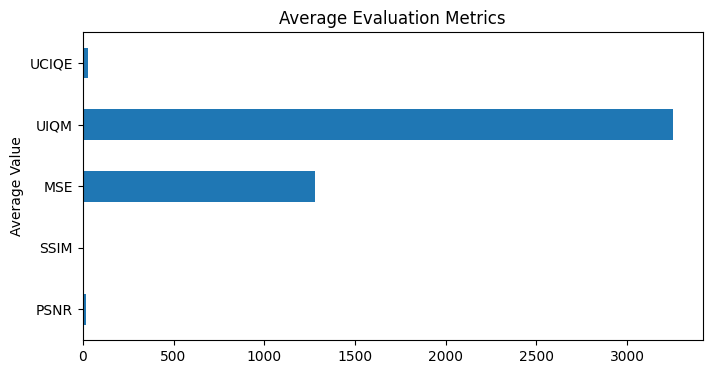

In [37]:
import matplotlib.pyplot as plt

numeric_metrics = metrics_df.select_dtypes(include=["number"])

avg_metrics = numeric_metrics.mean()
avg_metrics.plot(kind="barh", figsize=(8, 4), title="Average Evaluation Metrics")
plt.ylabel("Average Value")
plt.show()


## Improvement Visualization

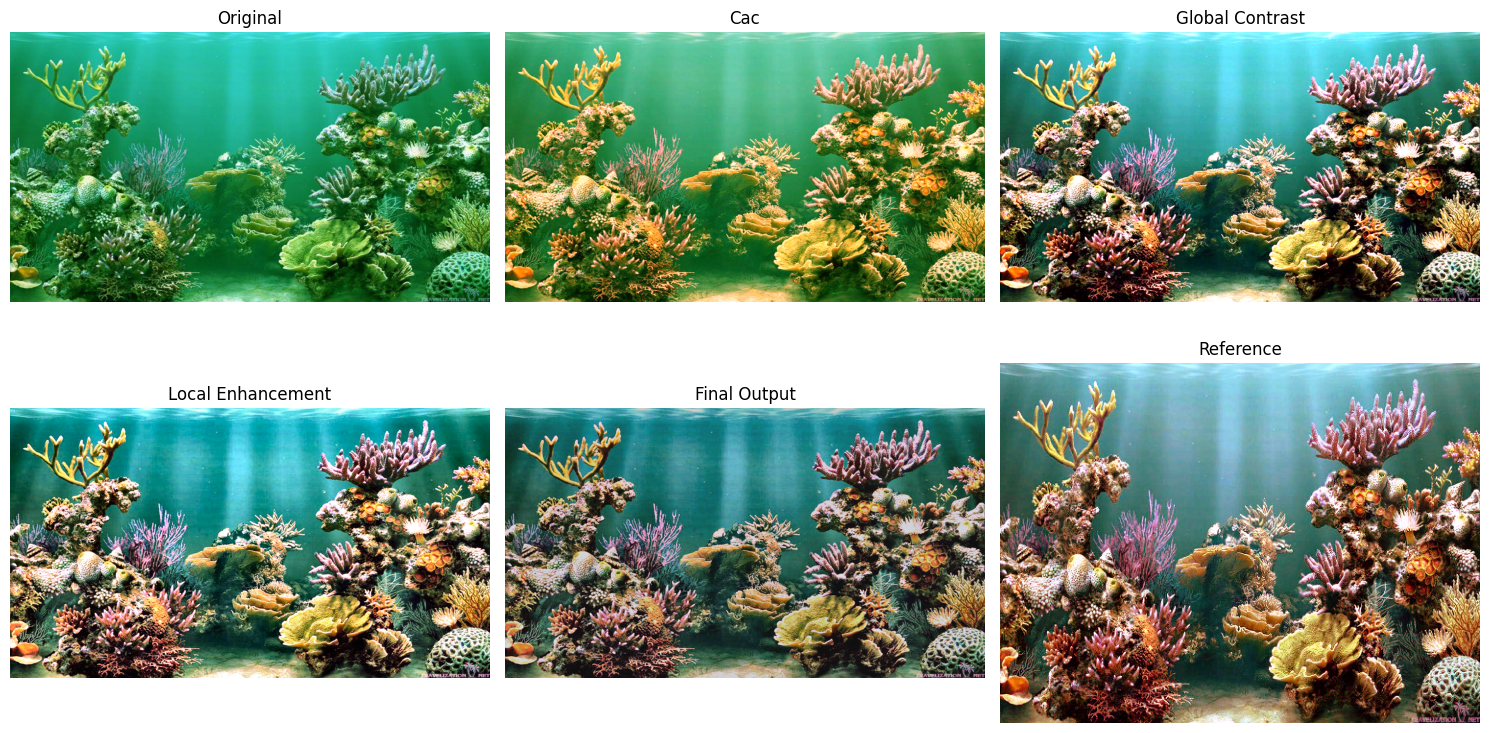

In [47]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_pipeline_results(outputs):
    """
    Plot intermediate results (images) from the enhancement pipeline,
    assigning subplot titles dynamically from the dictionary keys.

    Parameters:
        outputs (dict): A dictionary that may include:
            - Image keys (e.g. "original", "final") mapped to np.ndarray images (BGR).
            - Non-image keys (e.g. "metrics") mapped to other data types.
    """
    image_keys = [k for k, v in outputs.items() if isinstance(v, np.ndarray)]

    n_images = len(image_keys)
    if n_images == 0:
        print("No images to plot.")
        return

    n_cols = 3
    n_rows = math.ceil(n_images / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = np.array(axes).flatten()

    for idx, key in enumerate(image_keys):
        img_bgr = outputs[key]
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        axes[idx].imshow(img_rgb)
        title_str = " ".join([word.capitalize() for word in key.split("_")])
        axes[idx].set_title(title_str)

        axes[idx].axis("off")

    for j in range(n_images, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_pipeline_results(all_outputs['459_img_.png'])

# Challenging Images

In [51]:
%%time
random.seed(42)
input_folder = "/content/drive/MyDrive/UIEB_Dataset/challenging"
ref_folder = "/content/drive/MyDrive/UIEB_Dataset/reference"

input_files = sorted(os.listdir(input_folder))


n_total = len(input_files)
n_samples = 100 if n_total >= 100 else n_total

sample_indices = random.sample(range(n_total), n_samples)

all_outputs = {}


for idx in sample_indices:
    img_name = input_files[idx]

    img_path = os.path.join(input_folder, img_name)
    results = process_image_pipeline(img_path)
    all_outputs[img_name] = results

print("Processing complete. Stored outputs for", len(all_outputs), "images.")



Processing complete. Stored outputs for 60 images.
CPU times: user 1min 18s, sys: 481 ms, total: 1min 19s
Wall time: 2min 10s


In [52]:
metrics_list = []

for img_name, result in all_outputs.items():
    final_output = result["final_output"]
    ref_img = result.get("reference", None)
    metrics_dict = evaluate_image(final_output, ref_img)
    metrics_dict["image_name"] = img_name
    metrics_list.append(metrics_dict)

metrics_df = pd.DataFrame(metrics_list)
metrics_df.head()

PSNR  SSIM   MSE         UIQM      UCIQE image_name
0  None  None  None   611.555221  24.188019    432.png
1  None  None  None  1972.523698  26.509341  10488.png
2  None  None  None  4325.860546  26.977239  10091.png
3  None  None  None   352.646615  25.790252   6333.png
4  None  None  None   499.387172  25.472844  12972.png

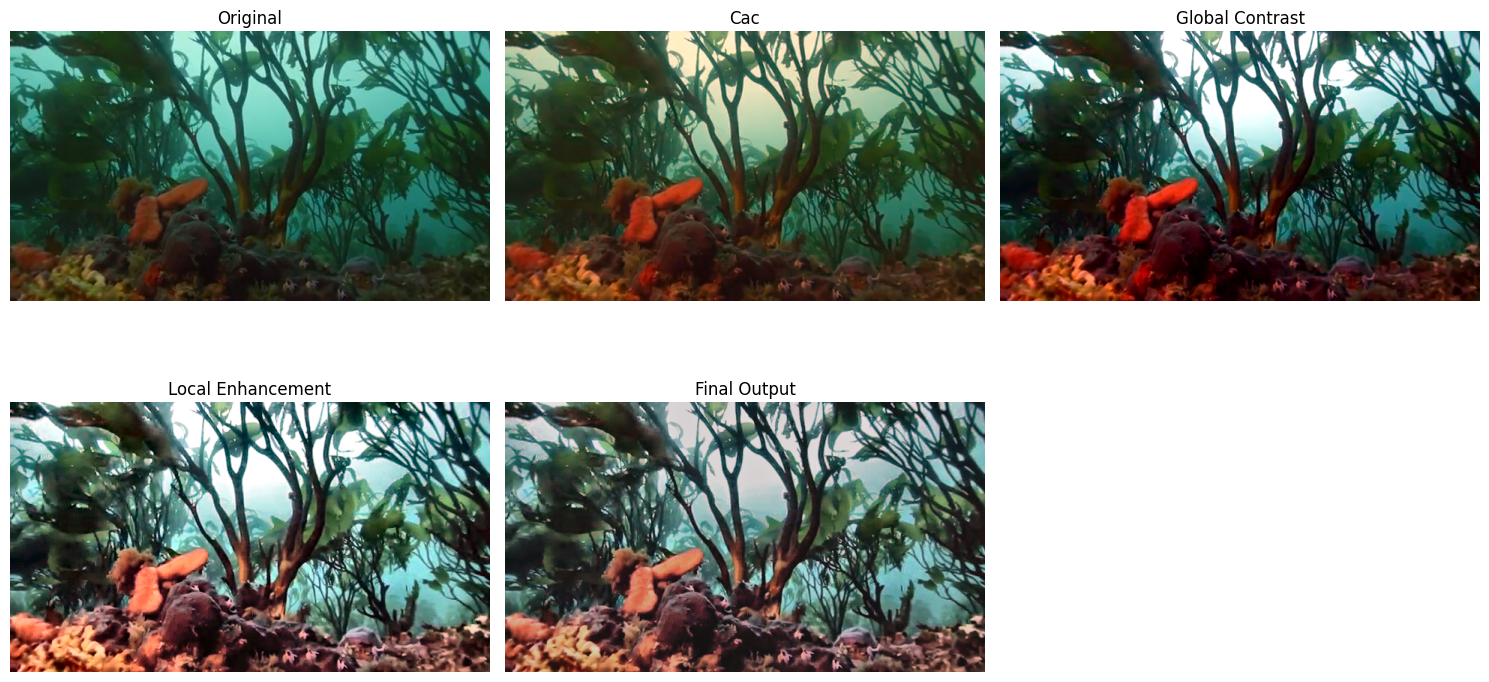

In [61]:
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_pipeline_results(outputs):
    """
    Plot intermediate results (images) from the enhancement pipeline,
    assigning subplot titles dynamically from the dictionary keys.

    Parameters:
        outputs (dict): A dictionary that may include:
            - Image keys (e.g. "original", "final") mapped to np.ndarray images (BGR).
            - Non-image keys (e.g. "metrics") mapped to other data types.
    """
    # Filter out any non-image entries
    image_keys = [k for k, v in outputs.items() if isinstance(v, np.ndarray)]

    n_images = len(image_keys)
    if n_images == 0:
        print("No images to plot.")
        return
    n_cols = 3
    n_rows = math.ceil(n_images / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = np.array(axes).flatten()

    for idx, key in enumerate(image_keys):
        img_bgr = outputs[key]
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        axes[idx].imshow(img_rgb)

        title_str = " ".join([word.capitalize() for word in key.split("_")])
        axes[idx].set_title(title_str)

        axes[idx].axis("off")
    for j in range(n_images, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

plot_pipeline_results(all_outputs['10091.png'])

In [53]:
all_outputs.keys()

dict_keys(['432.png', '10488.png', '10091.png', '6333.png', '12972.png', '12753.png', '12709.png', '12191.png', '9553.png', '10475.png', '579.png', '7277.png', '3201.png', '10226.png', '3494.png', '2575.png', '10103.png', '9602.png', '627.png', '12625.png', '770.png', '3087.png', '52.png', '3279.png', '12577.png', '6340.png', '2.png', '358_img_.png', '2583.png', '13252.png', '7291.png', '15775.png', '605.png', '100001.png', '15774.png', '5.png', '15738.png', '9618.png', '12228.png', '2856.png', '102.png', '6527.png', '15735.png', '10167.png', '643_img_.png', '3027.png', '616.png', '3051.png', '34.png', '12203.png', '13259.png', '3175.png', '9607.png', '880.png', '15603.png', '12960.png', '12565.png', '866.png', '15740.png', '3519.png'])

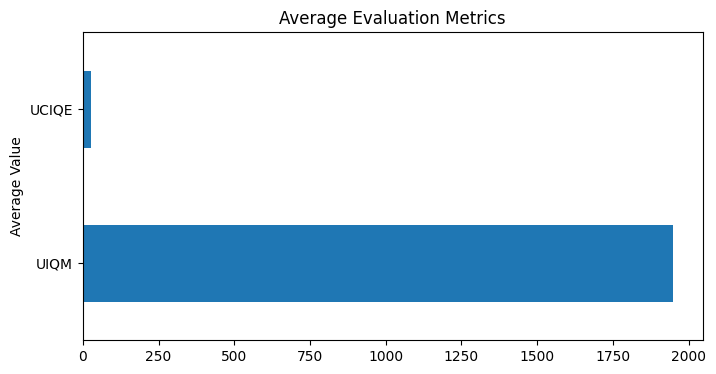

In [62]:
import matplotlib.pyplot as plt

numeric_metrics = metrics_df.select_dtypes(include=["number"])

avg_metrics = numeric_metrics.mean()
avg_metrics.plot(kind="barh", figsize=(8, 4), title="Average Evaluation Metrics")
plt.ylabel("Average Value")
plt.show()
